<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/main/Basics_of_lora_implementation_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from sklearn.datasets import load_iris
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import math

In [4]:
# Define a transform to normalize the data and flatten each image into a 1D array
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data)
    target = torch.tensor(target)
    return data.cuda(), target.cuda()

In [5]:
def plot_flattened_images(flattened_images, labels, img_shape, class_names, num_images=5):
    """
    Plots images that have been flattened.

    Parameters:
        flattened_images (torch.Tensor): The flattened images tensor.
        labels (torch.Tensor): The labels tensor.
        img_shape (tuple): The original shape of the images (e.g., (28, 28) for Fashion MNIST).
        class_names (list): List of class names.
        num_images (int): Number of images to plot.
    """
    # Reshape the flattened images back to their original shape
    reshaped_images = flattened_images.view(-1, *img_shape).numpy()

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

    for i, ax in enumerate(axes):
        img = reshaped_images[i]
        label = class_names[labels[i].item()]
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)


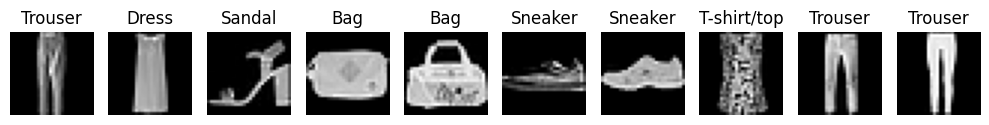

In [7]:
# Get one batch of images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [8]:

class FashionNet(nn.Module):
  def __init__(self, input_dims, num_class):

    super().__init__()
    self.input_dims = input_dims
    self.num_class = num_class

    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=1000)
    self.hidden_layer = nn.Linear(in_features=1000, out_features=2000)
    self.output_layer = nn.Linear(in_features=2000, out_features=self.num_class)

  def forward(self, x):
    out = F.relu(self.input_layer(x))
    out = F.relu(self.hidden_layer(out))
    out = self.output_layer(out)
    return out

In [9]:
# Check for GPU availability
cuda_available = torch.cuda.is_available()

In [10]:
BigNet = FashionNet(input_dims=784, num_class=len(class_names))
optimizer = optim.SGD(BigNet.parameters(), lr=0.011, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Assume `model` is your model
if cuda_available:
    BigNet = BigNet.to('cuda')
    optimizer = optim.SGD(BigNet.parameters(), lr=0.011, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to('cuda')

is_on_gpu = next(BigNet.parameters()).is_cuda
print(f'Model is on GPU: {is_on_gpu}')

trainable_params = sum(p.numel() for p in BigNet.parameters() if p.requires_grad)
print(f'Number of trainable (tunable) parameters: {trainable_params}')

Model is on GPU: True
Number of trainable (tunable) parameters: 2807010


In [12]:
import torch

def train_model(epochs:int, train_loader, model, optimizer, criterion):
  model.train()
  train_loss_per_epoch = []

  for epoch in range(epochs):

    running_loss_train = 0.0

    for data_batch, target_batch in train_loader:

        data_batch = data_batch.to('cuda')
        target_batch = target_batch.to('cuda')

        optimizer.zero_grad()
        output = model(data_batch)
        loss_train = criterion(output, target_batch)
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item()

    epcoh_loss_train = running_loss_train / len(train_loader)

    train_loss_per_epoch.append(epcoh_loss_train)


    if epoch %2 == 0:
      print(f'Epoch {epoch} Train loss {epcoh_loss_train}')
  return train_loss_per_epoch

device='cuda'

import torch
from sklearn.metrics import confusion_matrix
import numpy as np

def test(test_loader, net):
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = net(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the digit {i}: {wrong_counts[i]}')



In [13]:
trainLoss = train_model(epochs=6,
                        train_loader=trainloader,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

Epoch 0 Train loss 1.1822208863193706
Epoch 2 Train loss 0.4967660802905842
Epoch 4 Train loss 0.4332951130503315


In [21]:
# Call the function
test(
      test_loader=testloader,
      net=BigNet,
)

original_weights = {}
for name, param in BigNet.named_parameters():
    original_weights[name] = param.clone().detach()

Accuracy: 0.842
wrong counts for the digit 0: 176
wrong counts for the digit 1: 46
wrong counts for the digit 2: 261
wrong counts for the digit 3: 131
wrong counts for the digit 4: 267
wrong counts for the digit 5: 85
wrong counts for the digit 6: 407
wrong counts for the digit 7: 102
wrong counts for the digit 8: 45
wrong counts for the digit 9: 57


In [22]:
total_parameters_original = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010


In [34]:
# Load the entire dataset
full_trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

# Get the indices for the Shirt and T-shirt categories
shirt_tshirt_indices = [i for i, (data, target) in enumerate(full_trainset) if target == 2 or target == 6]
# Create a subset of the data for Shirt and T-shirt categories
shirt_tshirt_subset = torch.utils.data.Subset(full_trainset, shirt_tshirt_indices)
# Create the data loader for Shirt and T-shirt categories
pullover_tshirt_loader = torch.utils.data.DataLoader(shirt_tshirt_subset, batch_size=128, shuffle=True)



# Get the indices for the other categories (excluding Shirt and T-shirt)
indices_without_pullover_t_shirt = [i for i, (data, target) in enumerate(full_trainset) if target != 2 and target != 6]
# Create a subset of the data for other categories
other_subset = torch.utils.data.Subset(full_trainset, indices_without_pullover_t_shirt)
# Create the data loader for other categories
data_without_pullover_t_shirt = torch.utils.data.DataLoader(other_subset, batch_size=1024, shuffle=True)

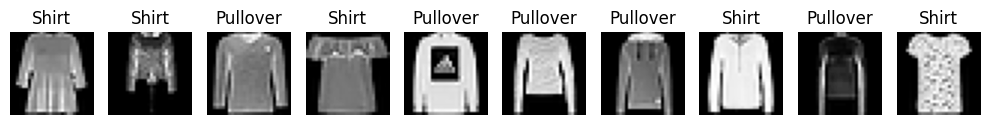

In [23]:
# Get one batch of images and labels
dataiter = iter(pullover_tshirt_loader)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [24]:
original_weights

{'input_layer.weight': tensor([[ 0.0197,  0.0173, -0.0302,  ..., -0.0137,  0.0043,  0.0150],
         [ 0.0269, -0.0136, -0.0200,  ..., -0.0299,  0.0093,  0.0179],
         [ 0.0087, -0.0007, -0.0085,  ...,  0.0330,  0.0182,  0.0002],
         ...,
         [-0.0104,  0.0193,  0.0150,  ..., -0.0051, -0.0331,  0.0051],
         [ 0.0036,  0.0179, -0.0149,  ...,  0.0064,  0.0305,  0.0181],
         [-0.0050, -0.0284, -0.0072,  ..., -0.0198,  0.0293,  0.0058]],
        device='cuda:0'),
 'input_layer.bias': tensor([ 2.7533e-03, -2.7529e-02,  8.5213e-03,  1.6714e-02,  2.6726e-03,
          3.9488e-03,  3.5662e-02, -1.8430e-02, -2.2621e-02, -4.9078e-03,
         -2.2960e-02, -3.3097e-02,  2.9027e-02, -1.8556e-02, -8.3636e-03,
          6.9052e-03, -9.6834e-03, -2.8241e-02,  2.3939e-02,  3.3533e-02,
         -1.4327e-02,  3.4082e-02,  2.9746e-02, -7.0173e-03,  1.1842e-02,
          4.8264e-03,  2.2918e-02, -2.2314e-02, -3.4910e-03,  3.6011e-02,
          2.6985e-02, -1.2994e-02, -2.9278e-02,

In [25]:
class LoRaParametarization(nn.Module):

    def __init__(self, r: int, lora_alpha: int, feature_in: int, feature_out:int):
        super().__init__()
        self.r = r
        self.lora_alpha = lora_alpha

        self.lora_A = nn.Parameter(torch.zeros(r, feature_out)).to('cuda')
        self.lora_B = nn.Parameter(torch.zeros(feature_in, r)).to('cuda')
        nn.init.normal_(self.lora_A, mean=0, std=1)

        self.scale = self.lora_alpha / self.r
        self.lora_enabled = True

    def forward(self, original_weights):

      if self.lora_enabled:
        return original_weights + torch.matmul(self.lora_B , self.lora_A).view(original_weights.shape) * self.scale
      return original_weights


def linear_layer_parameterization(layer, r:int=1, lora_alpha:int=1):

  feature_in, feature_out = layer.weight.shape

  return LoRaParametarization(r=r, lora_alpha=lora_alpha, feature_in=feature_in, feature_out=feature_out)

P.register_parametrization(BigNet.input_layer, "weight", linear_layer_parameterization(BigNet.input_layer))
P.register_parametrization(BigNet.hidden_layer, "weight", linear_layer_parameterization(BigNet.hidden_layer))
P.register_parametrization(BigNet.output_layer, "weight", linear_layer_parameterization(BigNet.output_layer))

def enable_disable_lora(enabled=True):
  for layer in [BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]:
    layer.parametrizations["weight"][0].enabled = enabled

In [26]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )
# The non-LoRA parameters count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000]) + Lora_A: torch.Size([1, 784]) + Lora_B: torch.Size([1000, 1])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000]) + Lora_A: torch.Size([1, 1000]) + Lora_B: torch.Size([2000, 1])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10]) + Lora_A: torch.Size([1, 2000]) + Lora_B: torch.Size([10, 1])
Total number of parameters (original): 2,807,010
Total number of parameters (original + LoRA): 2,813,804
Parameters introduced by LoRA: 6,794
Parameters incremment: 0.242%


In [43]:
enable_disable_lora(enabled=True)

In [35]:
# Freeze the non-Lora parameters
for name, param in BigNet.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False

trainLoss = train_model(epochs=4,
                        train_loader=pullover_tshirt_loader,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

Freezing non-LoRA parameter input_layer.bias
Freezing non-LoRA parameter input_layer.parametrizations.weight.original
Freezing non-LoRA parameter hidden_layer.bias
Freezing non-LoRA parameter hidden_layer.parametrizations.weight.original
Freezing non-LoRA parameter output_layer.bias
Freezing non-LoRA parameter output_layer.parametrizations.weight.original
Epoch 0 Train loss 0.7722027346174768
Epoch 2 Train loss 0.7726277328552084


In [36]:
BigNet.input_layer.parametrizations.weight.original

Parameter containing:
tensor([[ 0.0197,  0.0173, -0.0302,  ..., -0.0137,  0.0043,  0.0150],
        [ 0.0269, -0.0136, -0.0200,  ..., -0.0299,  0.0093,  0.0179],
        [ 0.0087, -0.0007, -0.0085,  ...,  0.0330,  0.0182,  0.0002],
        ...,
        [-0.0104,  0.0193,  0.0150,  ..., -0.0051, -0.0331,  0.0051],
        [ 0.0036,  0.0179, -0.0149,  ...,  0.0064,  0.0305,  0.0181],
        [-0.0050, -0.0284, -0.0072,  ..., -0.0198,  0.0293,  0.0058]],
       device='cuda:0')

In [37]:
original_weights['input_layer.weight']

tensor([[ 0.0197,  0.0173, -0.0302,  ..., -0.0137,  0.0043,  0.0150],
        [ 0.0269, -0.0136, -0.0200,  ..., -0.0299,  0.0093,  0.0179],
        [ 0.0087, -0.0007, -0.0085,  ...,  0.0330,  0.0182,  0.0002],
        ...,
        [-0.0104,  0.0193,  0.0150,  ..., -0.0051, -0.0331,  0.0051],
        [ 0.0036,  0.0179, -0.0149,  ...,  0.0064,  0.0305,  0.0181],
        [-0.0050, -0.0284, -0.0072,  ..., -0.0198,  0.0293,  0.0058]],
       device='cuda:0')

In [38]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(BigNet.input_layer.parametrizations.weight.original == original_weights['input_layer.weight'])
assert torch.all(BigNet.hidden_layer.parametrizations.weight.original == original_weights['hidden_layer.weight'])
assert torch.all(BigNet.output_layer.parametrizations.weight.original == original_weights['output_layer.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(BigNet.input_layer.weight, BigNet.input_layer.parametrizations.weight.original + (BigNet.input_layer.parametrizations.weight[0].lora_B @ BigNet.input_layer.parametrizations.weight[0].lora_A) * BigNet.input_layer.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(BigNet.input_layer.weight, original_weights['input_layer.weight'])

In [39]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test(
      test_loader=testloader,
      net=BigNet,
)

'''
Accuracy: 0.842
wrong counts for the digit 0: 176
wrong counts for the digit 1: 46
wrong counts for the digit 2: 261
wrong counts for the digit 3: 131
wrong counts for the digit 4: 267
wrong counts for the digit 5: 85
wrong counts for the digit 6: 407
wrong counts for the digit 7: 102
wrong counts for the digit 8: 45
wrong counts for the digit 9: 57
'''

Accuracy: 0.842
wrong counts for the digit 0: 176
wrong counts for the digit 1: 46
wrong counts for the digit 2: 261
wrong counts for the digit 3: 131
wrong counts for the digit 4: 267
wrong counts for the digit 5: 85
wrong counts for the digit 6: 407
wrong counts for the digit 7: 102
wrong counts for the digit 8: 45
wrong counts for the digit 9: 57


'\nAccuracy: 0.842\nwrong counts for the digit 0: 176\nwrong counts for the digit 1: 46\nwrong counts for the digit 2: 261\nwrong counts for the digit 3: 131\nwrong counts for the digit 4: 267\nwrong counts for the digit 5: 85\nwrong counts for the digit 6: 407\nwrong counts for the digit 7: 102\nwrong counts for the digit 8: 45\nwrong counts for the digit 9: 57\n'

In [28]:
trainLoss

[0.7823840975761414, 0.7831056217352549]

In [29]:
# Call the function
testlLoss, wrong_pred = test_model(
                        test_loader=testloader,
                        model=BigNet,
                        criterion=criterion,
                        class_labels=class_names)

In [30]:
wrong_pred

{'T-shirt/top': 204,
 'Trouser': 50,
 'Pullover': 322,
 'Dress': 142,
 'Coat': 265,
 'Sandal': 61,
 'Shirt': 377,
 'Sneaker': 111,
 'Bag': 65,
 'Ankle boot': 74}

In [37]:
enable_disable_lora(enabled=False)
# Call the function
testlLoss, wrong_pred = test_model(
                        test_loader=testloader,
                        model=BigNet,
                        criterion=criterion,
                        class_labels=class_names)
wrong_pred

{'T-shirt/top': 238,
 'Trouser': 42,
 'Pullover': 283,
 'Dress': 130,
 'Coat': 206,
 'Sandal': 52,
 'Shirt': 294,
 'Sneaker': 85,
 'Bag': 33,
 'Ankle boot': 52}

In [42]:
original_weights

{'input_layer.weight': tensor([[ 0.0197,  0.0173, -0.0302,  ..., -0.0137,  0.0043,  0.0150],
         [ 0.0269, -0.0136, -0.0200,  ..., -0.0299,  0.0093,  0.0179],
         [ 0.0087, -0.0007, -0.0085,  ...,  0.0330,  0.0182,  0.0002],
         ...,
         [-0.0104,  0.0193,  0.0150,  ..., -0.0051, -0.0331,  0.0051],
         [ 0.0036,  0.0179, -0.0149,  ...,  0.0064,  0.0305,  0.0181],
         [-0.0050, -0.0284, -0.0072,  ..., -0.0198,  0.0293,  0.0058]],
        device='cuda:0'),
 'input_layer.bias': tensor([ 2.7533e-03, -2.7529e-02,  8.5213e-03,  1.6714e-02,  2.6726e-03,
          3.9488e-03,  3.5662e-02, -1.8430e-02, -2.2621e-02, -4.9078e-03,
         -2.2960e-02, -3.3097e-02,  2.9027e-02, -1.8556e-02, -8.3636e-03,
          6.9052e-03, -9.6834e-03, -2.8241e-02,  2.3939e-02,  3.3533e-02,
         -1.4327e-02,  3.4082e-02,  2.9746e-02, -7.0173e-03,  1.1842e-02,
          4.8264e-03,  2.2918e-02, -2.2314e-02, -3.4910e-03,  3.6011e-02,
          2.6985e-02, -1.2994e-02, -2.9278e-02,

In [43]:
enable_disable_lora(enabled=False)

weights_with_lora = {}
for name, parm in BigNet.named_parameters():
  weights_with_lora[param] = parm.clone().detach()


In [47]:
weights_with_lora

{Parameter containing:
 tensor([[-0.0074, -0.0447,  0.0054,  ..., -0.0309, -0.0571, -0.0172],
         [-0.0420, -0.0185,  0.0039,  ...,  0.0019, -0.0512, -0.0310],
         [-0.0373,  0.0322,  0.0150,  ..., -0.0176,  0.0114,  0.0010],
         ...,
         [ 0.0695, -0.0223,  0.0078,  ...,  0.0421,  0.0039,  0.0302],
         [-0.0059,  0.0028, -0.0080,  ..., -0.0317,  0.0659, -0.0167],
         [ 0.0066,  0.0347, -0.0103,  ..., -0.0149,  0.0111,  0.0562]],
        device='cuda:0'): tensor([[-0.0074, -0.0447,  0.0054,  ..., -0.0309, -0.0571, -0.0172],
         [-0.0420, -0.0185,  0.0039,  ...,  0.0019, -0.0512, -0.0310],
         [-0.0373,  0.0322,  0.0150,  ..., -0.0176,  0.0114,  0.0010],
         ...,
         [ 0.0695, -0.0223,  0.0078,  ...,  0.0421,  0.0039,  0.0302],
         [-0.0059,  0.0028, -0.0080,  ..., -0.0317,  0.0659, -0.0167],
         [ 0.0066,  0.0347, -0.0103,  ..., -0.0149,  0.0111,  0.0562]],
        device='cuda:0')}